# Feedforward Neural Network (FNN)

A **feedforward neural network (FNN)** is one of the simplest types of artificial neural networks.

## 1. Structure
- **Input layer** – receives the input features (data).
- **Hidden layer(s)** – processes the inputs through weighted connections and activation functions.
- **Output layer** – produces the final prediction or result.

> Connections are **one-way**: signals move **forward** from input to output during the pass forward. There are **no cycles or loops**, unlike recurrent neural networks.

## 2. How it Works
1. Each neuron receives inputs, multiplies them by weights, adds a bias, and passes the result through an **activation function**:
$$
y = f(sum(w_i * x_i) + b)
$$
2. The output of one layer becomes the input for the next layer.
3. The network learns by **adjusting weights and biases** to minimize the difference between predicted output and true output (using backpropagation and gradient descent).

## 3. Key Characteristics
- **Directional flow:** Input → Hidden → Output (no loops).
- **Universal function approximator:** Can approximate almost any function with enough neurons and layers.
- **Used for:** Regression, classification, and pattern recognition tasks.

## 4. Example Visualization
```
Input Layer      Hidden Layer       Output Layer
   x1  ----\
   x2  ----> (h1) ----\
   x3  ----> (h2) ----> y_pred
              (h3) ----/
```

In short, a feedforward network is like a **pipeline**: information flows straight through the layers without feedback.



## Demo
This demo is to do handwritten digit classification using feed forward neural network. We will use MINST dataset.

- MINST
- Dataloader, Transformation
- Multilyaer Neural Network, Activation Function
- Loss and Optimizer
- Training loop (batch training)
- Model Evaluation
- GPU Support

In [13]:
from torch._C import device
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyper parameters
input_size = 784 # Because input MINST images are of 28 x 28 pixels
hidden_size = 128 # hidden layer neurons
num_classes = 10 # 10 different hand-written digits in MINST (0...9)
num_epochs = 2
batch_size = 100
learning_rate = 0.001

torch.Size([100, 1, 28, 28]) torch.Size([100])


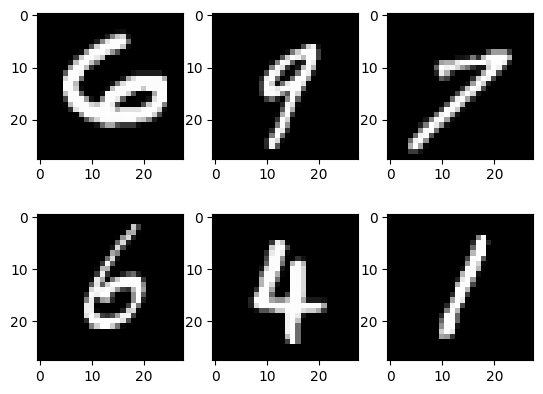

In [14]:
# Load Dataset

#Note: ToTensor() converts the numpy to tensor. And it automatically normalizes the image from [0, 255] → [0.0, 1.0].
transform = transforms.Compose(
    [transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root='./data',
                          train=True,
                          transform=transform,
                          download=True)
test_dataset = torchvision.datasets.MNIST(root='./data',
                          train=False,
                          transform=transform,
                          download=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader =  DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=True)

examples = iter(train_loader)
samples, labels = next(examples)
# samples is of batch_size x 1 x 28 x 28 shape. The gray image has one channel, image is of 28x28 pixels.
# labels is scalar value. You have batch_size no of values for that many number of images.
print(samples.shape, labels.shape)

for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.imshow(samples[i][0], cmap='gray')
plt.show()


In [15]:
import torch
import torch.nn as nn

# Feedforward Neural Network
# "Feedforward" means data flows strictly in one direction — from input to output (no feedback loops)
class FeedForwardNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedForwardNeuralNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # Fully connected layer: input → hidden
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        # Fully connected layer: hidden → output
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        return out  # No softmax here — CrossEntropyLoss applies it internally

# Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 28 * 28  # Flattened 28x28 image
hidden_size = 128
num_classes = 10      # Digits 0–9
learning_rate = 0.001
num_epochs = 5

model = FeedForwardNeuralNet(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop (assumes train_loader is defined)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Reshape image batch from (batch_size, 1, 28, 28) → (batch_size, 784)
        # Each image is flattened from 2D (28x28) to 1D (784 pixels)
        images = images.reshape(-1, 28 * 28).to(device)

        # Labels are a 1D tensor of size (batch_size)
        # Each element represents the true class (digit 0–9)
        labels = labels.to(device)
        # print(f"labels: {labels[0]}")

        # Forward pass: compute model output for current batch
        outputs = model(images)

        # 'outputs' has shape (batch_size, num_classes)
        # Each row corresponds to one image, and each column is the raw score (logit) for a digit (0–9)
        # Example (one row): tensor([-0.0985, -0.3098, -0.0237, -0.0554, 0.1347, -0.0641, -0.1058, 0.4386, 0.0659, 0.1407])
        # print(f"outputs: {outputs[0]}")

        # Compute the loss between predicted scores (logits) and true labels
        # CrossEntropyLoss internally applies softmax + negative log-likelihood (NLLLoss)
        # Softmax converts each row of logits into probabilities across classes
        # Then, for each image, it compares the probability of the true class (from 'labels') to compute the loss
        loss = criterion(outputs, labels)


        # Backpropagation
        optimizer.zero_grad()   # Reset gradients
        loss.backward()         # Compute new gradients
        optimizer.step()        # Update model parameters

        if (i + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, Step {i + 1}, Loss: {loss.item():.4f}")

# Evaluation loop (assumes test_loader is defined)
# The goal here is to check how well the trained model performs on unseen test data.
# We disable gradient computation since we’re not training — this saves memory and computation.
with torch.no_grad():
    n_correct = 0  # Counter for correctly predicted images
    n_samples = 0  # Counter for total images evaluated

    # Iterate through test dataset batches
    for images, labels in test_loader:
        # Flatten each 28x28 image into a 1D vector of 784 pixels
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)

        # Forward pass through the model → get raw output scores (logits)
        outputs = model(images)

        # Get the class index with the highest score for each image
        # torch.max returns both (max_value, index); we only need the index (predicted class)
        _, predictions = torch.max(outputs, 1)

        # Update total and correct counts
        n_samples += labels.size(0)  # Add number of images in this batch
        n_correct += (predictions == labels).sum().item()  # Count where prediction == true label

    # Compute and display overall accuracy
    # Accuracy = (correct predictions / total samples) * 100
    print(f'Accuracy: {100 * n_correct / n_samples:.2f}%')



Epoch 1, Step 100, Loss: 0.3764
Epoch 1, Step 200, Loss: 0.3064
Epoch 1, Step 300, Loss: 0.2621
Epoch 1, Step 400, Loss: 0.2044
Epoch 1, Step 500, Loss: 0.2676
Epoch 1, Step 600, Loss: 0.1670
Epoch 2, Step 100, Loss: 0.1351
Epoch 2, Step 200, Loss: 0.2118
Epoch 2, Step 300, Loss: 0.1723
Epoch 2, Step 400, Loss: 0.2845
Epoch 2, Step 500, Loss: 0.1075
Epoch 2, Step 600, Loss: 0.2047
Epoch 3, Step 100, Loss: 0.1324
Epoch 3, Step 200, Loss: 0.0738
Epoch 3, Step 300, Loss: 0.0931
Epoch 3, Step 400, Loss: 0.1328
Epoch 3, Step 500, Loss: 0.1469
Epoch 3, Step 600, Loss: 0.0538
Epoch 4, Step 100, Loss: 0.1188
Epoch 4, Step 200, Loss: 0.0683
Epoch 4, Step 300, Loss: 0.1199
Epoch 4, Step 400, Loss: 0.0919
Epoch 4, Step 500, Loss: 0.0374
Epoch 4, Step 600, Loss: 0.1741
Epoch 5, Step 100, Loss: 0.0948
Epoch 5, Step 200, Loss: 0.1178
Epoch 5, Step 300, Loss: 0.0620
Epoch 5, Step 400, Loss: 0.0603
Epoch 5, Step 500, Loss: 0.0509
Epoch 5, Step 600, Loss: 0.0610
Accuracy: 97.30%
